In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import data

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


## Scaling membantu RNN

In [ ]:
# df.Temp = df.Temp.transform(lambda x: (x-x.mean()) / x.std())

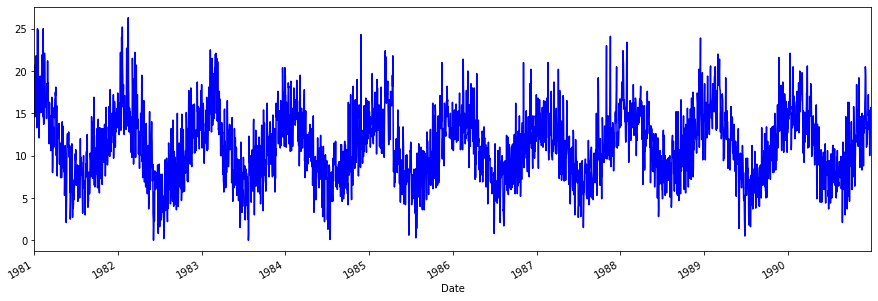

In [5]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape,ts_test.shape

((2920, 5), (730, 5))

## Dataset & Dataloader

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [8]:
bs = 32
seq_len = 14

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, num_workers=4)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 5)
Note: last 7 data excluded

(N, S, F): (52, 14, 5)
Note: last 1 data excluded



## Arsitektur & Config

In [9]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layer, dropout, batch_first=True):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layer, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [10]:
config = set_config({
    "input_size": 5, #train_set.n_feature
    "output_size": 1,
    "seq_len": 14,
    "bs": 32,
    "hidden_size": 64,
    "num_layer": 2,
    "drop_out": 0
})

## Training Preparation => MCOC

In [11]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layer, config.drop_out).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

## Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 129.0711 | Test_cost  = 120.4510 | 




Epoch     2
Train_cost  = 102.7635 | Test_cost  = 93.5272 | 




Epoch     3
Train_cost  = 78.1550 | Test_cost  = 71.9179 | 




Epoch     4
Train_cost  = 60.9775 | Test_cost  = 59.2438 | 




Epoch     5
Train_cost  = 50.9671 | Test_cost  = 51.1081 | 




Epoch     6
Train_cost  = 44.1765 | Test_cost  = 44.9589 | 




Epoch     7
Train_cost  = 38.9124 | Test_cost  = 39.9639 | 




Epoch     8
Train_cost  = 34.6182 | Test_cost  = 35.8079 | 




Epoch     9
Train_cost  = 31.0612 | Test_cost  = 32.3281 | 




Epoch    10
Train_cost  = 28.1092 | Test_cost  = 29.4176 | 




Epoch    11
Train_cost  = 25.6688 | Test_cost  = 26.9943 | 




Epoch    12
Train_cost  = 23.6653 | Test_cost  = 24.9895 | 




Epoch    13
Train_cost  = 22.0346 | Test_cost  = 23.3432 | 




Epoch    14
Train_cost  = 20.7203 | Test_cost  = 22.0020 | 




Epoch    15
Train_cost  = 19.6720 | Test_cost  = 20.9178 | 




Epoch    16
Train_cost  = 18.8448 | Test_cost  = 20.0480 | 




Epoch    17
Train_cost  = 18.1989 | Test_cost  = 19.3552 | 




Epoch    18
Train_cost  = 17.6998 | Test_cost  = 18.8069 | 




Epoch    19
Train_cost  = 17.3181 | Test_cost  = 18.3752 | 




Epoch    20
Train_cost  = 17.0288 | Test_cost  = 18.0368 | 


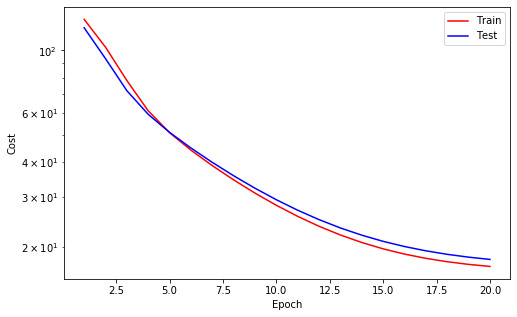



Epoch    21
Train_cost  = 16.8114 | Test_cost  = 17.7725 | 




Epoch    22
Train_cost  = 16.6491 | Test_cost  = 17.5663 | 




Epoch    23
Train_cost  = 16.5286 | Test_cost  = 17.4055 | 




Epoch    24
Train_cost  = 16.4393 | Test_cost  = 17.2800 | 




Epoch    25
Train_cost  = 16.3730 | Test_cost  = 17.1818 | 




Epoch    26
Train_cost  = 16.3235 | Test_cost  = 17.1046 | 




Epoch    27
Train_cost  = 16.2861 | Test_cost  = 17.0436 | 




Epoch    28
Train_cost  = 16.2573 | Test_cost  = 16.9950 | 




Epoch    29
Train_cost  = 16.2344 | Test_cost  = 16.9558 | 




Epoch    30
Train_cost  = 16.2156 | Test_cost  = 16.9237 | 




Epoch    31
Train_cost  = 16.1993 | Test_cost  = 16.8970 | 




Epoch    32
Train_cost  = 16.1845 | Test_cost  = 16.8741 | 




Epoch    33
Train_cost  = 16.1702 | Test_cost  = 16.8537 | 




Epoch    34
Train_cost  = 16.1555 | Test_cost  = 16.8346 | 




Epoch    35
Train_cost  = 16.1394 | Test_cost  = 16.8155 | 




Epoch    36
Train_cost  = 16.1206 | Test_cost  = 16.7945 | 




Epoch    37
Train_cost  = 16.0971 | Test_cost  = 16.7689 | 




Epoch    38
Train_cost  = 16.0654 | Test_cost  = 16.7344 | 




Epoch    39
Train_cost  = 16.0206 | Test_cost  = 16.6866 | 




Epoch    40
Train_cost  = 15.9577 | Test_cost  = 16.6187 | 


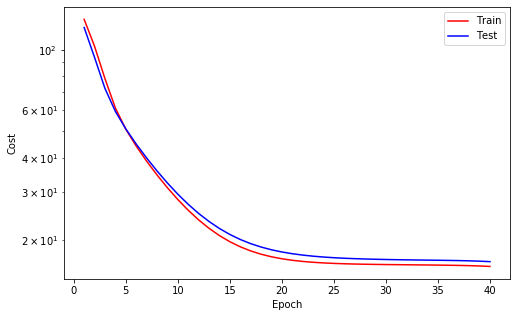



Epoch    41
Train_cost  = 15.8631 | Test_cost  = 16.5050 | 




Epoch    42
Train_cost  = 15.6978 | Test_cost  = 16.2833 | 




Epoch    43
Train_cost  = 15.3736 | Test_cost  = 15.8723 | 




Epoch    44
Train_cost  = 14.8527 | Test_cost  = 15.3057 | 




Epoch    45
Train_cost  = 14.0639 | Test_cost  = 14.1717 | 




Epoch    46
Train_cost  = 12.8416 | Test_cost  = 12.8672 | 




Epoch    47
Train_cost  = 11.8455 | Test_cost  = 12.0380 | 




Epoch    48
Train_cost  = 11.2294 | Test_cost  = 11.2839 | 




Epoch    49
Train_cost  = 10.5695 | Test_cost  = 10.6504 | 




Epoch    50
Train_cost  = 10.0621 | Test_cost  = 10.0546 | 




Epoch    51
Train_cost  = 9.5968 | Test_cost  = 9.5257 | 




Epoch    52
Train_cost  = 9.2172 | Test_cost  = 9.0902 | 




Epoch    53
Train_cost  = 8.8893 | Test_cost  = 8.7343 | 




Epoch    54
Train_cost  = 8.6227 | Test_cost  = 8.4326 | 




Epoch    55
Train_cost  = 8.3956 | Test_cost  = 8.1598 | 


KeyboardInterrupt: 

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [12]:
from luwiji.rnn import illustration

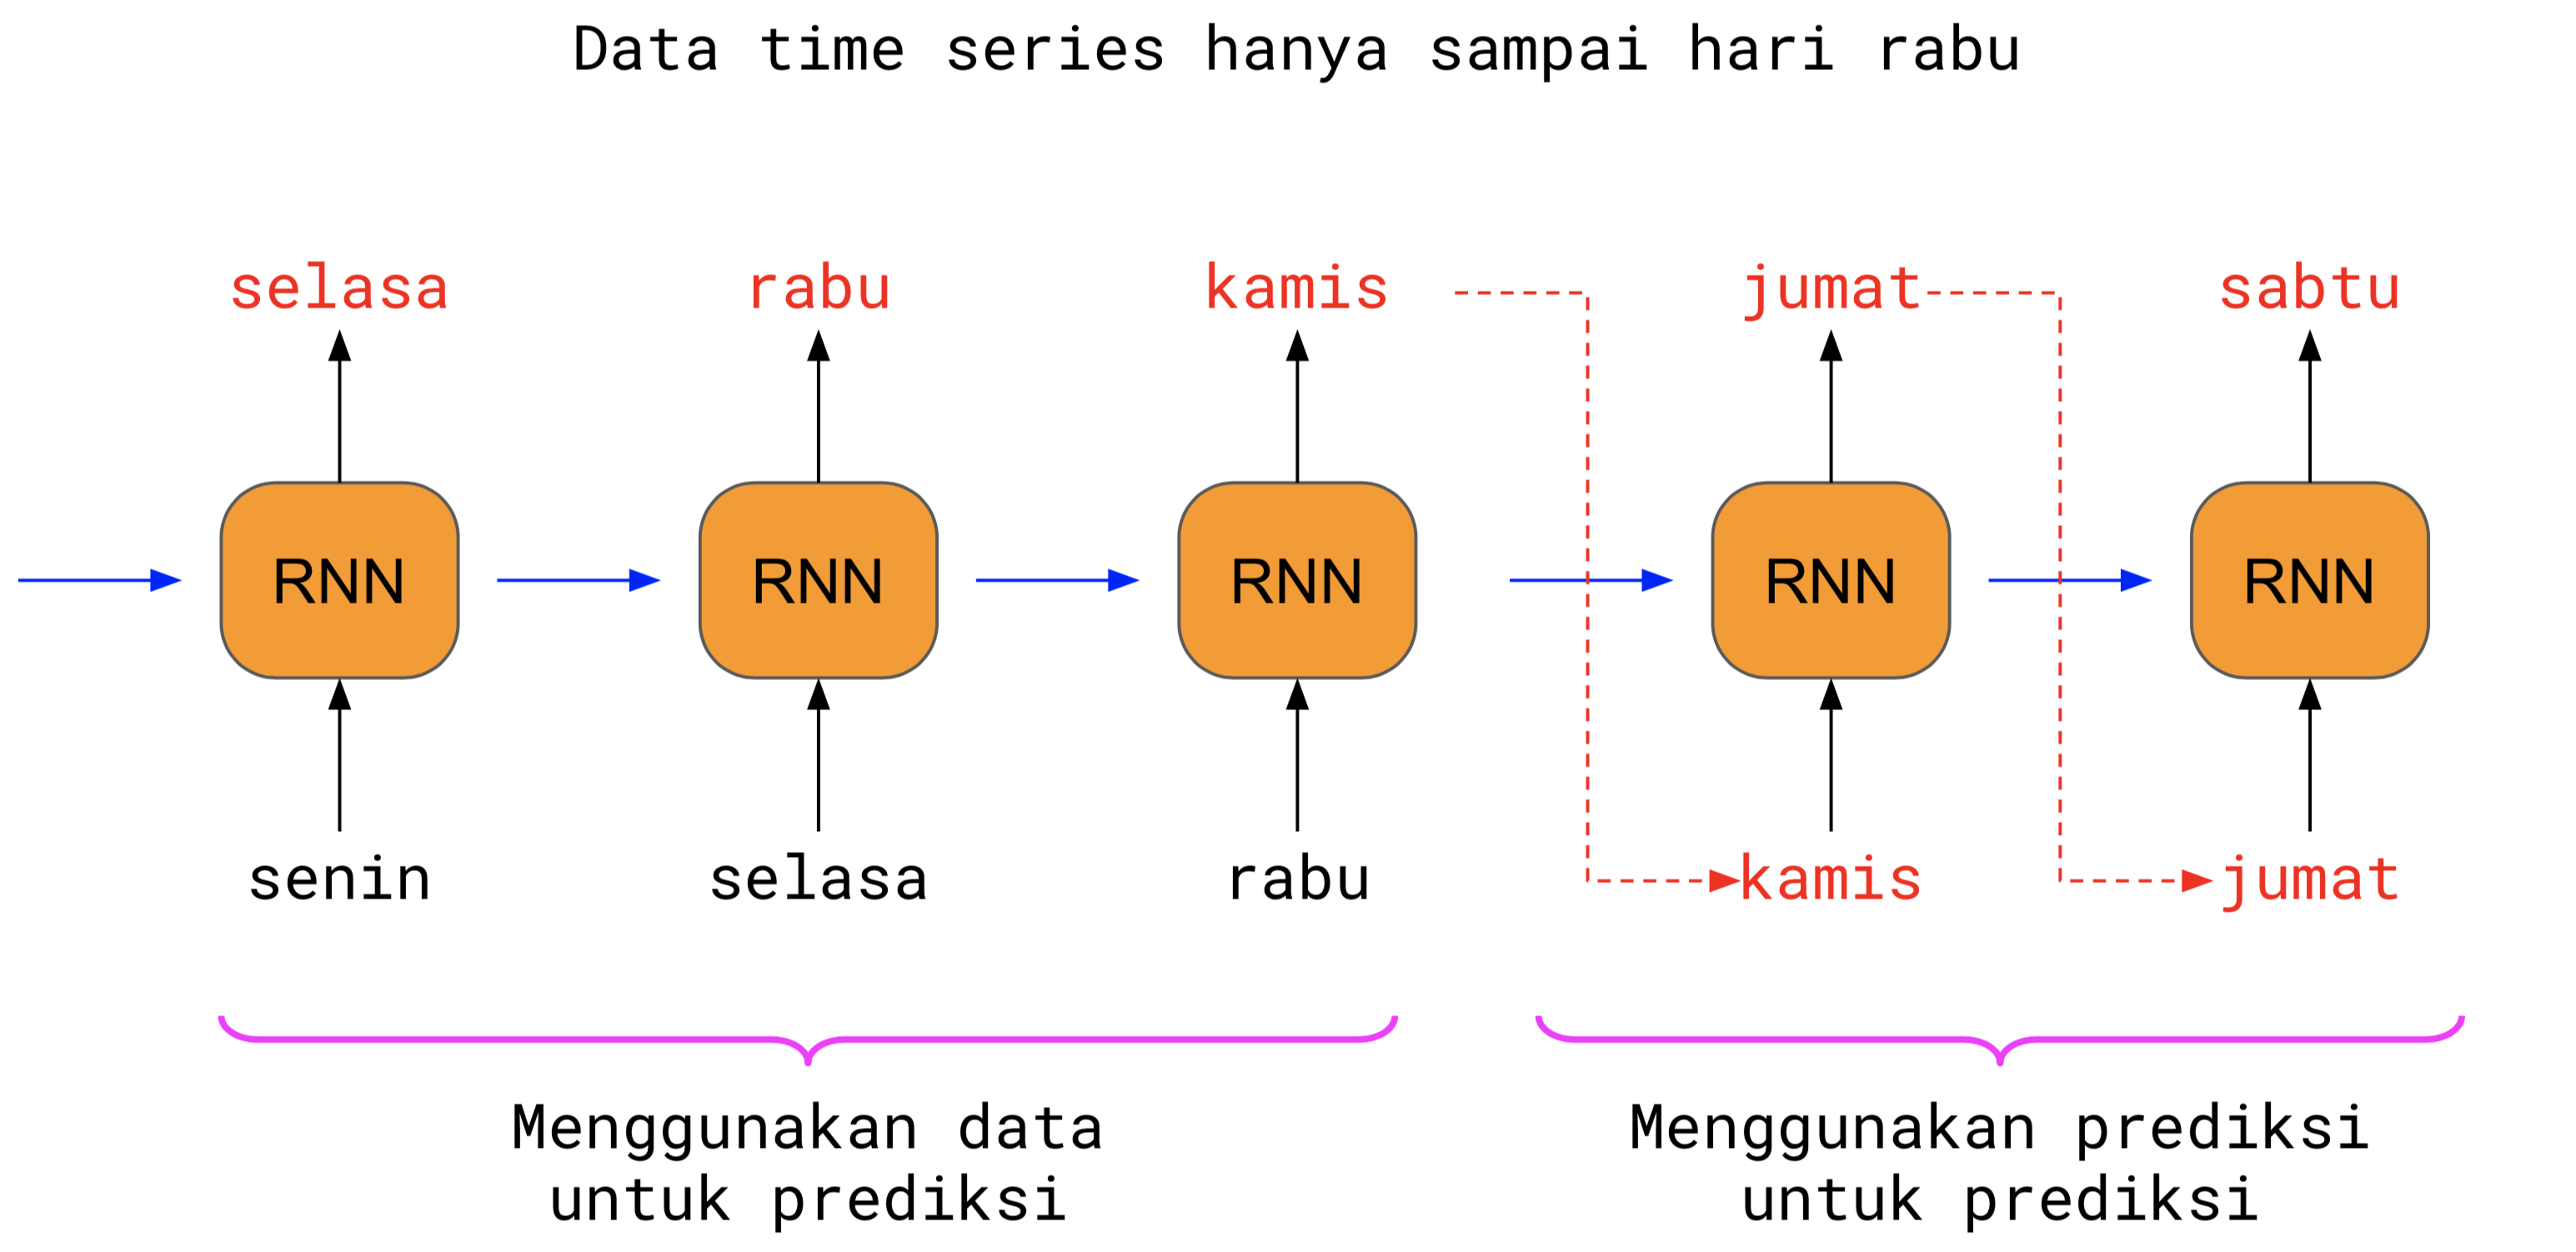

In [13]:
illustration.forecast

In [14]:
from utils import data4pred, pred4pred

In [15]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

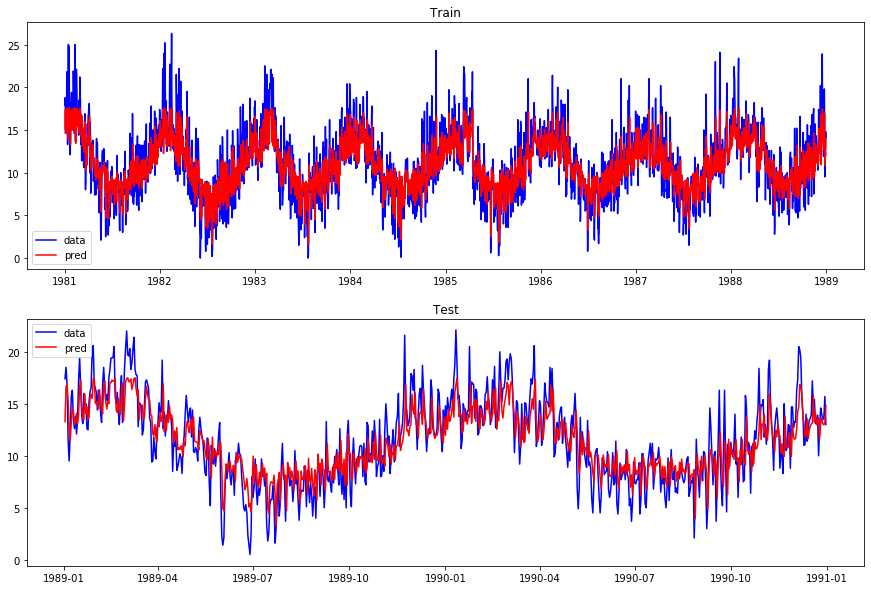

In [16]:
# Data for Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

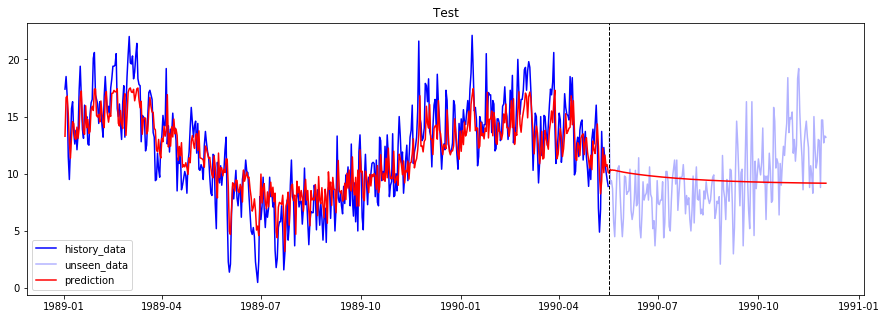

In [17]:
# Pred for Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")